In [10]:
# imports
import argparse
from argparse import Namespace

from pytorch_lightning import Trainer, LightningModule, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
from torchsummary import summary

from yeastdnnexplorer.data_loaders.synthetic_data_loader import SyntheticDataLoader
from yeastdnnexplorer.ml_models.simple_model import SimpleModel
from yeastdnnexplorer.ml_models.customizable_model import CustomizableModel

import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from yeastdnnexplorer.probability_models.relation_classes import Relation, And, Or
from yeastdnnexplorer.probability_models.generate_data import (
    perturbation_effect_adjustment_function_with_tf_relationships,
    perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic
)

seed_everything(42)

Seed set to 42


42

In this notebook, we train an identical model on data gnenerating using our 4 mean adjustment methods
1. No adjustment
2. Adjust all tf means
3. Adjust tf means only if certain other tfs are bound for the gene
4. Adjust mean only if a list of boolean relations are satisfied among which TFs are bound for the current gene

Define Checkpoints and Loggers for our models to use

In [11]:
best_model_checkpoint = ModelCheckpoint(
    monitor="val_mse",
    mode="min",
    filename="best-model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

# Callback to save checkpoints every 5 epochs, regardless of performance
periodic_checkpoint = ModelCheckpoint(
    filename="periodic-{epoch:02d}",
    every_n_epochs=2,
    save_top_k=-1,  # Setting -1 saves all checkpoints
)

# define loggers for the model
tb_logger = TensorBoardLogger("logs/tensorboard_logs")
csv_logger = CSVLogger("logs/csv_logs")

We define a few helper functions to run our experiment. We make helper functions for the data module and the model since they will be mostly the same across experiemnts.

In [13]:
def get_data_module(max_mean_adjustment, adjustment_function, tf_relationships_dict = {}):
    return SyntheticDataLoader(
        batch_size=32,
        num_genes=4000,
        signal_mean=3.0,
        signal=[0.5] * 10,
        n_sample=[1, 2, 2, 4, 4],  # sum of this is num of tfs
        val_size=0.1,
        test_size=0.1,
        random_state=42,
        max_mean_adjustment=max_mean_adjustment,
        adjustment_function=adjustment_function,
        tf_relationships=tf_relationships_dict,
    )

def get_model(num_tfs):
    return CustomizableModel(
        input_dim=num_tfs,
        output_dim=num_tfs,
        lr=0.01,
        hidden_layer_num=2,
        hidden_layer_sizes=[64, 32],
        activation="LeakyReLU",
        optimizer="RMSprop",
        L2_regularization_term=0.0,
        dropout_rate=0.0,
    )

Run our experiment for the model trained on data with no mean adjustments (achieved by setting max_mean_adjustment to 0)

In [4]:
# define dictionary of relations between TFs
data_module = get_data_module(0.0, None, None)
num_tfs = sum(data_module.n_sample)  # sum of all n_sample is the number of TFs
model = get_model(num_tfs)

trainer = Trainer(
    max_epochs=10,
    deterministic=True,
    accelerator="cpu",
    callbacks=[best_model_checkpoint, periodic_checkpoint],
    logger=[tb_logger, csv_logger],
)

trainer.fit(model, data_module)

test_results = trainer.test(model, datamodule=data_module)
print("Printing test results...")
print(test_results)  # this prints all metrics that were logged during the test phase

# print summary of model
print("Printing model summary...")
summary(model, (num_tfs, num_tfs))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/benmueller/2024Classes/BrentResearch/git

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mse            1.5734728574752808
       test_nrmse           0.22200515866279602
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing test results...
[{'test_mse': 1.5734728574752808, 'test_nrmse': 0.22200515866279602}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 13, 64]             896
         LeakyReLU-2               [-1, 13, 64]               0
           Dropout-3               [-1, 13, 64]               0
            Linear-4               [-1, 13, 32]         

Run our experiment for the model trained on data with the default mean adjustments

In [5]:
# define dictionary of relations between TFs
data_module = get_data_module(3.0, None, None)
num_tfs = sum(data_module.n_sample)  # sum of all n_sample is the number of TFs
model = get_model(num_tfs)

trainer = Trainer(
    max_epochs=10,
    deterministic=True,
    accelerator="cpu",
    callbacks=[best_model_checkpoint, periodic_checkpoint],
    logger=[tb_logger, csv_logger],
)

trainer.fit(model, data_module)

test_results = trainer.test(model, datamodule=data_module)
print("Printing test results...")
print(test_results)  # this prints all metrics that were logged during the test phase

# print summary of model
print("Printing model summary...")
summary(model, (num_tfs, num_tfs))

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/.venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory logs/tensorboard_logs/lightning_logs/version_85/checkpoints exists and is not empty.

  | Name          | Type       | Params
---------------------------------------------
0 | r2            | R2Score    | 0     
1 | activation    | LeakyReLU  | 0     
2 | input_layer   | Linear     | 896   
3 | hidden_layers | ModuleList | 2.1 K 
4 | output_layer  | Linear     | 429   
5 | dropout       | Dropout    | 0     
---------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mse            2.1843292713165283
       test_nrmse           0.21009229123592377
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing test results...
[{'test_mse': 2.1843292713165283, 'test_nrmse': 0.21009229123592377}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 13, 64]             896
         LeakyReLU-2               [-1, 13, 64]               0
           Dropout-3               [-1, 13, 64]               0
            Linear-4               [-1, 13, 32]         

Run our experiment for the model with the integer relations (only unary relations, no binary / boolean logic)

In [6]:
# define dictionary of relations between TFs
tf_relationships_dict = {
    0: [2, 4, 7],
    1: [8],
    2: [3, 9],
    3: [1, 6],
    4: [5],
    5: [0, 2, 8],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [0, 3, 8],
}

data_module = get_data_module(
    3.0, 
    perturbation_effect_adjustment_function_with_tf_relationships, 
    tf_relationships_dict
)
num_tfs = sum(data_module.n_sample)  # sum of all n_sample is the number of TFs
model = get_model(num_tfs)

trainer = Trainer(
    max_epochs=10,
    deterministic=True,
    accelerator="cpu",
    callbacks=[best_model_checkpoint, periodic_checkpoint],
    logger=[tb_logger, csv_logger],
)

trainer.fit(model, data_module)

test_results = trainer.test(model, datamodule=data_module)
print("Printing test results...")
print(test_results)  # this prints all metrics that were logged during the test phase

# print summary of model
print("Printing model summary...")
summary(model, (num_tfs, num_tfs))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name          | Type       | Params
---------------------------------------------
0 | r2            | R2Score    | 0     
1 | activation    | LeakyReLU  | 0     
2 | input_layer   | Linear     | 896   
3 | hidden_layers | ModuleList | 2.1 K 
4 | output_layer  | Linear     | 429   
5 | dropout       | Dropout    | 0     
---------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mse            1.7407374382019043
       test_nrmse           0.2069530338048935
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing test results...
[{'test_mse': 1.7407374382019043, 'test_nrmse': 0.2069530338048935}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 13, 64]             896
         LeakyReLU-2               [-1, 13, 64]               0
           Dropout-3               [-1, 13, 64]               0
            Linear-4               [-1, 13, 32]           

Run our experiment for the model with the boolean relations:

In [7]:

# NOTE that we can pass in the same number twice to a relation to make it a unary relation
# you can also pass as many arguments as you want to a relation to make it a n-ary relation
tf_relationships_dict_boolean_logic = {
    0: [And(3, 4, 8), Or(3, 7), Or(1, 1)],
    1: [And(5, Or(7, 8))],
    2: [],
    3: [Or(7, 9)],
    4: [And(1, 2)],
    5: [Or(1, 2)],
    6: [And(4, Or(9, 7))],
    7: [Or(5, And(2, 3))],
    8: [And(6, 4)],
    9: [],
}

data_module = get_data_module(
    3.0, 
    perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic, 
    tf_relationships_dict_boolean_logic
)
num_tfs = sum(data_module.n_sample)  # sum of all n_sample is the number of TFs
model = get_model(num_tfs)

trainer = Trainer(
    max_epochs=10,
    deterministic=True,
    accelerator="cpu",
    callbacks=[best_model_checkpoint, periodic_checkpoint],
    logger=[tb_logger, csv_logger],
)

trainer.fit(model, data_module)

test_results = trainer.test(model, datamodule=data_module)
print("Printing test results...")
print(test_results)  # this prints all metrics that were logged during the test phase

# print summary of model
print("Printing model summary...")
summary(model, (num_tfs, num_tfs))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name          | Type       | Params
---------------------------------------------
0 | r2            | R2Score    | 0     
1 | activation    | LeakyReLU  | 0     
2 | input_layer   | Linear     | 896   
3 | hidden_layers | ModuleList | 2.1 K 
4 | output_layer  | Linear     | 429   
5 | dropout       | Dropout    | 0     
---------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mse             1.715409755706787
       test_nrmse           0.20101304352283478
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing test results...
[{'test_mse': 1.715409755706787, 'test_nrmse': 0.20101304352283478}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 13, 64]             896
         LeakyReLU-2               [-1, 13, 64]               0
           Dropout-3               [-1, 13, 64]               0
            Linear-4               [-1, 13, 32]          

We would also like to run the same experiments for the simple linear model to have a benchmark / baseline to compare to

In [15]:
# Setup and Helper Functions =================================================
def get_linear_model(num_tfs):
    return SimpleModel(
        input_dim=num_tfs,
        output_dim=num_tfs,
        lr=0.01
    )

def print_results(model, test_results, num_tfs):
    print("Printing test results...")
    print(test_results)  # this prints all metrics that were logged during the test phase

    # print summary of model
    print("Printing model summary...")
    summary(model, (num_tfs, num_tfs))

def get_trainer():
    return Trainer(
        max_epochs=10,
        deterministic=True,
        accelerator="cpu",
        callbacks=[best_model_checkpoint],
        logger=[tb_logger, csv_logger],
    )

best_model_checkpoint = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    filename="best-model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

# for the dependent mean adjustment (experiment 2)
tf_relationships_dict = {
    0: [2, 4, 7],
    1: [8],
    2: [3, 9],
    3: [1, 6],
    4: [5],
    5: [0, 2, 8],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [0, 3, 8],
}

# for the mean adjustments with boolean logic (experiment 3)
tf_relationships_dict_boolean_logic = {
    0: [And(3, 4, 8), Or(3, 7), Or(1, 1)],
    1: [And(5, Or(7, 8))],
    2: [],
    3: [Or(7, 9)],
    4: [And(1, 2)],
    5: [Or(1, 2)],
    6: [And(4, Or(9, 7))],
    7: [Or(5, And(2, 3))],
    8: [And(6, 4)],
    9: [],
}

    
# First experiment (no mean adjustment) =====================================

data_module = get_data_module(0.0, None, None)
num_tfs = sum(data_module.n_sample)  # sum of all n_sample is the number of TFs
model = get_linear_model(num_tfs)

trainer = get_trainer()
trainer.fit(model, data_module)

test_results = trainer.test(model, datamodule=data_module)
print_results(model, test_results, num_tfs)


# Second experiment (TF dependent mean adjustment) ===========================
data_module = get_data_module(
    3.0, 
    perturbation_effect_adjustment_function_with_tf_relationships, 
    tf_relationships_dict
)
num_tfs = sum(data_module.n_sample)  # sum of all n_sample is the number of TFs
model = get_linear_model(num_tfs)

trainer = get_trainer()
trainer.fit(model, data_module)

test_results = trainer.test(model, datamodule=data_module)
print_results(model, test_results, num_tfs)


# Third experiment (TF dependent mean adjustment with boolean logic) ==========

data_module = get_data_module(
    3.0, 
    perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic, 
    tf_relationships_dict_boolean_logic
)
num_tfs = sum(data_module.n_sample)  # sum of all n_sample is the number of TFs
model = get_linear_model(num_tfs)

trainer = get_trainer()
trainer.fit(model, data_module)

test_results = trainer.test(model, datamodule=data_module)
print_results(model, test_results, num_tfs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:256: UserWarning: To copy construct from a tensor, it is recommended

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.91326904296875
        test_mape           22.939716339111328
       test_nrmse           0.24038974940776825
         test_r2           -0.013859041035175323
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Printing test results...
[{'test_loss': 1.91326904296875, 'test_nrmse': 0.24038974940776825, 'test_mape': 22.939716339111328, 'test_r2': -0.013859041035175323}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 13, 13]             182
Total params: 182
Trainable params: 182
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/.venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory logs/tensorboard_logs/lightning_logs/version_86/checkpoints exists and is not empty.

  | Name    | Type                        | Params
--------------------------------------------------------
0 | mape    | MeanAbsolutePercentageError | 0     
1 | r2      | R2Score                     | 0     
2 | linear1 | Linear                      | 182   
--------------------------------------------------------
182       Trainable params
0         Non-trainable params
182       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             2.5683434009552
        test_mape            11.32097053527832
       test_nrmse           0.2422269582748413
         test_r2           -0.039482638239860535
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Printing test results...
[{'test_loss': 2.5683434009552, 'test_nrmse': 0.2422269582748413, 'test_mape': 11.32097053527832, 'test_r2': -0.039482638239860535}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 13, 13]             182
Total params: 182
Trainable params: 182
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------



  | Name    | Type                        | Params
--------------------------------------------------------
0 | mape    | MeanAbsolutePercentageError | 0     
1 | r2      | R2Score                     | 0     
2 | linear1 | Linear                      | 182   
--------------------------------------------------------
182       Trainable params
0         Non-trainable params
182       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.693371295928955
        test_mape           17.527084350585938
       test_nrmse           0.24757595360279083
         test_r2           -0.012163707055151463
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing test results...
[{'test_loss': 2.693371295928955, 'test_nrmse': 0.24757595360279083, 'test_mape': 17.527084350585938, 'test_r2': -0.012163707055151463}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 13, 13]             182
Total params: 182
Tra

Plotting Results

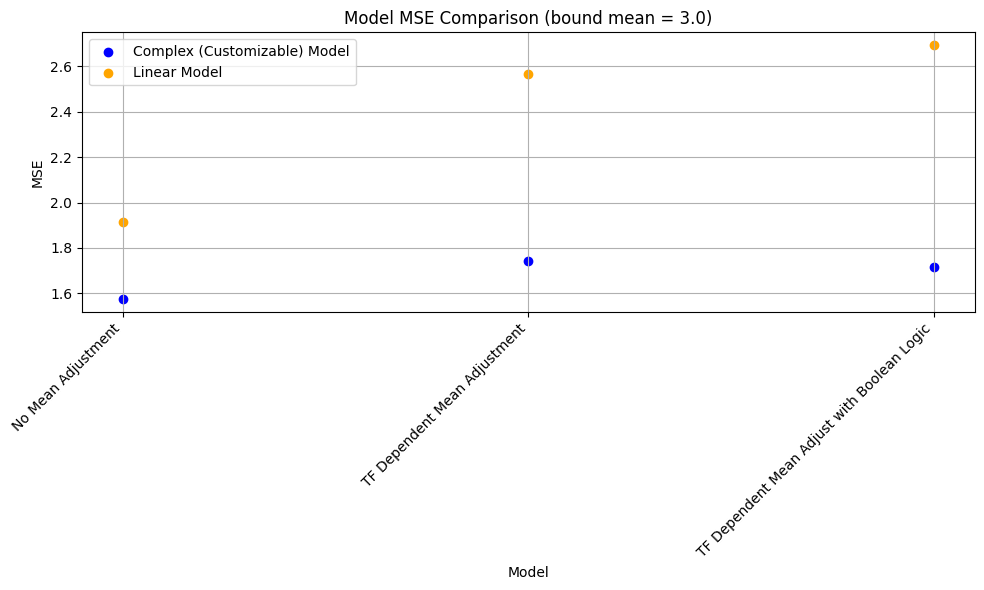

In [18]:
models = ["No Mean Adjustment", "TF Dependent Mean Adjustment", "TF Dependent Mean Adjust with Boolean Logic"]
mses = [1.5734, 1.7407, 1.7154]
linear_mses = [1.9133, 2.568, 2.6934]

plt.figure(figsize=(10, 6))
plt.scatter(models, mses, color='blue')
plt.scatter(models, linear_mses, color='orange')
plt.title('Model MSE Comparison (bound mean = 3.0)')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.grid(True)
plt.xticks(rotation=45, ha="right")
plt.legend(['Complex (Customizable) Model', 'Linear Model'])
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()